In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erf
import torchdiffeq
from torchdiffeq import odeint_adjoint, odeint
import numpy as np

### Initialize state

In [2]:
n_sheeps = 40
n_sheperds = 6

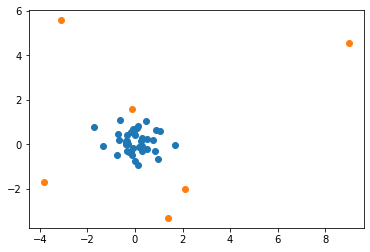

In [3]:
A = torch.randn((n_sheeps, 2))/2
S = torch.randn((n_sheperds, 2))*3
V = torch.randn((n_sheeps, 2))/4
A_COM = A.mean(dim=0)
S_COM = S.mean(dim=0)

plt.scatter(A[:,0],A[:,1])
plt.scatter(S[:,0],S[:,1])

### Forces & Functions

tensor([[-3.7151e-03, -6.7262e-03],
        [ 2.6738e-04, -9.2054e-02],
        [-1.1698e-02,  2.3384e-02],
        [ 4.1074e-03, -7.0416e-02],
        [ 2.7765e-02, -1.0420e-01],
        [ 4.6623e-03, -1.0975e-01],
        [-5.9521e-03, -1.6844e-02],
        [-2.9691e-02, -4.3302e-02],
        [-9.6202e-03, -7.1596e-03],
        [ 3.4559e-03, -5.8397e-02],
        [ 6.2454e-03, -2.6564e-02],
        [ 1.1716e-02, -3.3299e-02],
        [-6.3710e-05, -4.1553e-03],
        [-6.8599e-03, -8.0047e-02],
        [-9.2056e-03, -1.1497e-02],
        [-1.1536e-02, -3.4396e-02],
        [-1.2591e-02,  7.0211e-05],
        [ 1.4371e-02, -2.4223e-02],
        [-1.5090e-02, -5.8598e-02],
        [-8.9507e-03, -2.6889e-02],
        [ 2.3332e-04, -1.4394e-02],
        [ 1.4378e-02, -1.1040e-02],
        [-1.1098e-02, -3.3371e-02],
        [-1.6154e-02,  4.9198e-03],
        [ 3.6728e-02, -1.9335e-02],
        [-1.8313e-02, -2.9348e-02],
        [ 4.1652e-02, -1.3231e-01],
        [-1.4217e-01, -1.250

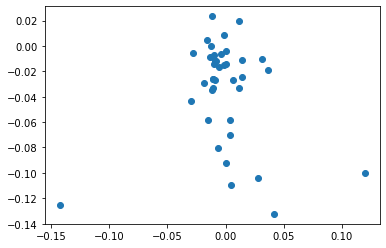

In [4]:
def ss_repulsion(A, S, α=0.1, r=0.1):
    F_r = torch.zeros_like(A)
    for s in S:
        Δ = A - s
        d = torch.norm(Δ, p=2, dim=-1, keepdim=True) # torch.sqrt(torch.sum(Δ**2, 1))
        f = α * Δ / (d**3)
        F_r = F_r + f
    #norm = torch.sum(F_r**2, 1)
    #idx = norm > r
    #F_r[idx] = torch.FloatTensor([0.1,0.1])
#    for i in range(A.size()[0]):
#        if F_r[i][0]**2+F_r[i][1]**2 > thresh_ss:
#            F_r[i][0] = 0.01
#            F_r[i][1] = 0.01
    return F_r

print(ss_repulsion(A, S))
plt.scatter(ss_repulsion(A,S)[:,0],ss_repulsion(A,S)[:,1])

In [5]:
def sheep_repulsion(A, β=0.1, r=0.5):
    F_r = torch.zeros_like(A)
    for a in A:
        Δ = A - a
        d = torch.norm(Δ, p=2, dim=-1, keepdim=True) # torch.sqrt(torch.sum(Δ**2, 1))
        f = β * Δ / (d**3)
        f = torch.nan_to_num(f)
        #idx = d<r  
        #f[idx.reshape(-1),:] = torch.zeros_like(a)
        #print(f)
        F_r += f
    return F_r

sheep_repulsion(A, β=0.1, r=0.5)

tensor([[ 2.8726e+00, -7.5483e+00],
        [-2.5937e+00,  9.7554e-01],
        [ 1.8946e+00, -2.0493e+00],
        [ 4.3748e+00,  5.9562e+00],
        [ 6.3262e+00, -2.5733e+00],
        [ 1.8747e+00,  2.3482e+01],
        [ 2.6747e+00,  1.3981e-01],
        [-4.4168e+00,  2.9955e+00],
        [ 1.9631e+00, -1.0608e+01],
        [ 6.3739e+00, -1.5393e+01],
        [-3.1642e-02, -2.8883e+00],
        [ 2.3337e+00,  6.6067e+00],
        [ 5.3259e+00, -2.1931e+00],
        [-1.5597e+01, -2.5731e+00],
        [-1.0537e+01, -1.0117e+01],
        [-1.2702e+02,  2.2940e+02],
        [-1.2254e-01, -3.0486e+00],
        [ 6.0336e+00,  1.7345e+00],
        [-5.7416e+00,  2.6581e+00],
        [ 2.6189e+01, -5.1537e+00],
        [ 1.1504e+01,  2.8241e+00],
        [ 4.5154e+00,  1.0366e-01],
        [ 1.2137e+02, -2.0201e+02],
        [ 1.4827e+00, -4.8242e+00],
        [-9.6780e-01,  2.6108e+00],
        [-6.6321e+00,  6.1050e-02],
        [ 4.0980e+00,  1.5299e+01],
        [-1.4490e+00,  2.292

In [6]:
def sheep_cohesion(A, A_COM, γ = 0.1):
    dA_COM = A_COM - A
    F_c = γ * dA_COM
    return F_c

sheep_cohesion(A,A_COM)

tensor([[-2.9870e-02,  4.1535e-02],
        [ 1.0175e-02, -4.8134e-02],
        [-9.7995e-02,  7.9034e-02],
        [ 3.3639e-03, -3.7032e-02],
        [-1.0068e-02, -5.7894e-02],
        [ 7.6248e-03, -5.5650e-02],
        [ 6.9326e-03,  2.9911e-02],
        [ 7.2433e-02, -3.2258e-02],
        [ 1.4600e-02,  6.2352e-02],
        [ 1.3919e-03, -2.8707e-02],
        [-2.7038e-02, -1.5598e-03],
        [-3.1367e-02, -1.4308e-02],
        [-5.2023e-02,  3.3645e-02],
        [ 1.7602e-02, -4.2004e-02],
        [ 2.5285e-02,  4.9154e-02],
        [ 3.6429e-02, -2.8495e-03],
        [ 1.2530e-04,  8.8073e-02],
        [-4.9692e-02, -1.2055e-02],
        [ 3.3243e-02, -2.9526e-02],
        [ 2.9097e-02,  1.0567e-02],
        [-2.7878e-02,  2.2237e-02],
        [-7.5795e-02, -6.2973e-03],
        [ 3.5441e-02, -1.1124e-03],
        [-1.0512e-02,  1.0690e-01],
        [-8.9327e-02, -5.2982e-02],
        [ 6.7911e-02, -4.7468e-03],
        [-1.0861e-02, -6.8192e-02],
        [ 6.4973e-02, -9.716

In [7]:
F_A = sheep_cohesion(A,A_COM) + sheep_repulsion(A) + ss_repulsion(A,S)

### Gaussian distribution
##### sigma = standard deviation
##### mu = expected value = COM

In [8]:
def gaussian(A, a_COM, sigma=0.1):
    mu = a_COM
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(A-mu)**2 / (2 * sigma**2))
    return y

### Compose the vector field and the ODE

$x \mapsto \dot x$

$(A, s) \mapsto (\dot A, \dot s)$

In [9]:
class ODEFunc(nn.Module):
    def __init__(self, π:nn.Module, n_sheeps:int, r=0.15):
        super().__init__()
        self.π = π
        self.r = r
        self.n_sheeps = n_sheeps
    
    def forward(self, t, X):
        # A: batch, N_SHEEPS, 2
        # V: batch, N_SHEEPS, 2
        # s: batch, 1, 2
        # x: batch, N_SHEEPS + 1, 2
        # π: batch, 2(N_SHEEPS + 1) --> batch, 2 
        
        # unpack state
        X = (A, V, S)
        # compute forces
        F_coh = sheep_cohesion(A,A_COM)
        F_srep = sheep_repulsion(A, β=0.1, r=0.5)
        F_ctrl = ss_repulsion(A, S, α=0.1, r=0.1)
        # compute vector field
        dAdt = V
        dVdt = F_coh + 0.01*F_srep + F_ctrl 
        
        # naive policy
        z = torch.cat([A.reshape(1,-1), V.reshape(1,-1), S.reshape(1,-1)], 1)
        dSdt = self.π(z).reshape(-1,2) #self.π(A, V, S)
        return (dAdt, dVdt, dSdt)

`nn.Linear(n, m)`

$$
 y = W x + b
$$

with $x\in R^n$ and $y\in R^m$

In [10]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_sheeps, n_shepherds, latent_dim=32, hid_dim=64):
        super().__init__()
        self.n_sheeps, self.n_shepherds = n_sheeps, n_shepherds
        
        self.l_A = nn.Linear(n_sheeps*2, latent_dim)
        self.l_V = nn.Linear(n_sheeps*2, latent_dim)
        self.l_S = nn.Linear(n_shepherds*2, latent_dim)
        
        self.policy_net = nn.Sequential(
            nn.Linear(latent_dim, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, hid_dim),
            nn.Tanh(),
            nn.Linear(hid_dim, n_shepherds*2)
        )
        
    def forward(self, A, V, S):
        # A, V, S --> π(A,V,S)
        # embed A, V and S in a latent space of dimension "latent_dim" then pass it to the policy net
        A, V, S = A.reshape(-1, self.n_sheeps*2), V.reshape(-1, self.n_sheeps*2), S.reshape(-1, self.n_shepherds*2)
        z = self.l_A(A) + self.l_V(V) + self.l_S(S)
        return self.policy_net(z).reshape(-1, 2)
        

In [11]:
A0, V0, S0 = A, V, S
X0 = (A0, V0, S0)
π = PolicyNetwork(len(A), len(S))
odefunc = ODEFunc(π, len(A))
π

PolicyNetwork(
  (l_A): Linear(in_features=80, out_features=32, bias=True)
  (l_V): Linear(in_features=80, out_features=32, bias=True)
  (l_S): Linear(in_features=12, out_features=32, bias=True)
  (policy_net): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
)

In [12]:
A = torch.randn((n_sheeps, 2))/2
S = torch.randn((n_sheperds, 2))*3
V = torch.randn((n_sheeps, 2))/4
A, S, V = A.requires_grad_(True), S.requires_grad_(True), V.requires_grad_(True)
X = (A, V, S)

_,_,y = odefunc(0,X)
y = y.sum()
y.backward()
A.grad

TypeError: forward() missing 2 required positional arguments: 'V' and 'S'

In [13]:
def euler(f, X, t_span):
    sol = tuple([el] for el in X)
    x = X
    for i in range(len(t_span)-1):
        f_ = f(t_span[i], x)
        x = tuple(el_x + (t_span[i+1] - t_span[i])*el_f for el_x, el_f in zip(x, f_))
        for el_sol, el_x in zip(sol, x): el_sol.append(el_x) 
    sol = tuple(torch.stack(el_sol) for el_sol in sol)
    return sol

$$
    ({\tt ODEFunc}, [A_0, s_0]) \mapsto [A(T), s(T)] 
$$

$\mapsto$: ODE solver

In [14]:
t_span = torch.linspace(0, 5, 100)

In [15]:
sol = euler(odefunc, X0, t_span)
sol_A, sol_V, sol_S = sol
sol_A, sol_V, sol_S = sol_A.detach(), sol_V.detach(), sol_S.detach()

plt.plot(sol_A[:,:,0], sol_A[:,:,1], 'b');
plt.plot(sol_S[:,:,0], sol_S[:,:,1], 'r');

TypeError: forward() missing 2 required positional arguments: 'V' and 'S'

### Train the policy $\pi$

In [17]:
N_SHEEPS = n_agents = 40
N_SHEPHERDS = 6
T = 40
H_DIM= 32
BS = 1024
EPOCHS = 5000

def loss_fn(A_T, A_COM_T, V):
    rogue_d = torch.cdist(A_T, A_COM_T)
    loss = torch.mean(rogue_d) + (A_COM_T-torch.FloatTensor([10,10])) + V
    return loss.mean()

π = nn.Sequential(
        nn.Linear(4*N_SHEEPS + 2*N_SHEPHERDS, H_DIM),
        nn.Softplus(),
        nn.Linear(H_DIM, H_DIM),
        nn.Tanh(),
        nn.Linear(H_DIM, 2*N_SHEPHERDS))

# π = PolicyNetwork(N_SHEEPS, N_SHEPHERDS)
odefunc = ODEFunc(π, N_SHEEPS, r=1)


opt = torch.optim.Adam(odefunc.parameters(), lr=1e-2)
X0 = (A0, V0, S0)
X0 = tuple(x.requires_grad_(True) for x in X0)

for epoch in range(EPOCHS):
    # sample initial conditions

    # integrate ODE between 0 and T
    sol = euler(odefunc, X0, torch.linspace(0, T, 30))
    sol_A, sol_V, _ = sol    
    loss = sol_A[-1].mean()
    #loss = loss_fn(A_T, A_COM_T, V)
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    with torch.no_grad():
        for p in π.parameters(): print(p.grad)
        print(f"epoch: {epoch},  loss:{loss}", end="\r")

None
None
None
None
None
None
Noneh: 0,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 1,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 2,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 3,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 4,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 5,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 6,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 7,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 8,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 9,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 10,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 11,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 12,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 13,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 14,  loss:-0.3314548134803772
None
None
None
None
None
Noneh: 15,  loss:-0.3314548134803772
None
None
Non

KeyboardInterrupt: 

In [22]:
sol_A, _, _  = euler(odefunc, X0, t_span)

In [24]:
y = sol_A[-1].sum()

In [25]:
y.backward()

In [26]:
for p in odefunc.parameters(): print(p.grad)

None
None
None
None
None
None


In [29]:
l = nn.Linear(10, 10)
x = torch.randn(100, 10)
y = l(x).sum()
y.backward()

for p in l.parameters(): print(p.grad)

tensor([[-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,  -9.4617, -10.9010,  -0.8697,
           4.0375,  -0.1822,  -5.0845],
        [-12.1966,  -8.7317,  -4.0128, -22.6198,

### Junk Test Codes

In [396]:
a=torch.randn(4,4)
torch.mean(a)

tensor(0.2315)

In [404]:
a=torch.FloatTensor([[0,0],[0,1]])
b=torch.FloatTensor([3,3])
c=torch.cdist(a, b, p=2)

RuntimeError: cdist only supports at least 2D tensors, X2 got: 1D